### import dependencies

In [176]:
import numpy as np
import scipy.io as sio
import os
import matplotlib
import matplotlib.pyplot as plt

### plotting utils

- The default configuration in Matplotlib may not be ideal (for instance, axis linewidths and fonts); better adjust and keep consistent across all the subplots. Refer to 'reset_rcparams()' below on how to adjust relevant parameters.
- Personally, I do not scale figures; instead, specify each subplot's size ahead (with respect to the bigger figure, for instance, 40mm x 40mm). 

In [98]:
def reset_rcparams():
    matplotlib.rcdefaults()
    matplotlib.rcParams['font.family'] = "Arial"
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['lines.linewidth'] = 0.8
    plt.rcParams['axes.labelpad'] = 2

    major = 2
    majorpad = 2
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['ytick.major.size'] = major
    plt.rcParams['xtick.major.width'] = 0.4
    plt.rcParams['ytick.major.width'] = 0.4
    plt.rcParams['xtick.major.pad'] = majorpad
    plt.rcParams['ytick.major.pad'] = majorpad
    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.rcParams['axes.labelsize'] = 5

    plt.rcParams["legend.borderpad"] = 0
    plt.rcParams["legend.framealpha"] = 0
    plt.rcParams["legend.fontsize"] = 5

def hide_axes_top_right(ax):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

def hide_axes_all(ax):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)

# every dimension is in millimeter
mm = 1/25.4

### Manage skeletal information

In [135]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

class PoseProfile:
    def __init__(
        self, 
        skeleton_name,
        skeleton_root='./skeletons'
    ):
        assert os.path.exists(skeleton_root), f"{skeleton_root} does not exist"

        _profiles = [f.split('.mat')[0] for f in os.listdir(skeleton_root) if f.endswith('.mat')]
        assert skeleton_name in _profiles, f"{skeleton_name} does not exist in {skeleton_root}"
        
        # load skeleton information ('./skeletons/*.mat')
        info = sio.loadmat(os.path.join(skeleton_root, f'{skeleton_name}.mat'))
        joint_names = info["joint_names"]
        self.joint_names = np.array([jn[0] for jn in joint_names[0]])
        self.n_joints = len(self.joint_names)
    
    def calibrate(self,
                  kpt_center,
                  indices_reorder,
    ):
        assert kpt_center < self.n_joints
        assert len(indices_reorder) <= self.n_joints

        self.kpt_center = kpt_center
        self.indices_reorder = np.array(indices_reorder)
        self.joint_names = self.joint_names[indices_reorder]
        self.n_joints = len(self.joint_names)
        print("\nAfter calibration:\n", 
              np.array([f"{jn} {idx}" for idx, jn in enumerate(self.joint_names)]))
        
    def set_kinematic_tree(self, kinematic_tree):
        self.kinematic_tree = kinematic_tree
        print("\nKinematic tree: ")
        for chain in self.kinematic_tree:
            print('Chain: ', [self.joint_names[idx] for idx in chain])
    
    def print_joint_names(self, print_indices=True):
        if print_indices:
            return np.array([f"{jn} {idx}" for idx, jn in enumerate(self.joint_names)])
        return self.joint_names
    
    def set_pose_alignment(self, anterior_idx, posterior_idx):
        self.anterior_idx = anterior_idx
        self.posterior_idx = posterior_idx
    
    def align_pose(self, poses, align_z=False):
        poses = poses[:, self.indices_reorder, :]
        traj = poses[:, :1]
        poses = poses - traj
        spineline = poses[:, self.anterior_idx] - poses[:, self.posterior_idx]
        spineline = spineline[:, None, :]
        if not align_z:
            spineline[:, :, 2] = 0
        spineline = unit_vector(spineline)

        # by default, align heading to the +x axis
        x_axis = np.zeros_like(spineline)
        x_axis[:, :, 0] = 1
    
        # rotation matrices
        rotmat = [rotation_matrix_from_vectors(vec1, vec2) for (vec1, vec2) in zip(spineline, x_axis)]
        rotmat = np.stack(rotmat, 0)

        poses_rot = rotmat @ poses.transpose((0, 2, 1))
        poses_rot = poses_rot.transpose((0, 2, 1))
        
        poses_rot = (poses_rot - poses_rot.min()) / (poses_rot.max() - poses_rot.min())
        poses_rot = 2*(poses_rot-0.5)
        
        return poses_rot, traj

# here we initialize the pose profile
# with some pre-defined skeleton .mat file
profile = PoseProfile(
    skeleton_name='mouse22',
    skeleton_root='./skeletons'
)
print("Joint names: \n", profile.print_joint_names(True))

# typically, raw pose sequences need to be aligned and reordered
profile.calibrate(
    kpt_center=4,
    indices_reorder=[4, 3, 0, 1, 2, 5, 11, 10 ,9, 8, 15, 14, 13, 12, 18, 17, 16, 21, 20, 19]
)

# a kinematic tree consists of several kinematic chain, along anatomical structures (e.g., limbs),
# need these for plotting
# refer to the previous printouts for their definitions
kinematic_tree = [
    [0, 1, 2, 3, 4, 2],
    [0, 5],
    [1, 6, 7, 8, 9],
    [1, 10, 11, 12, 13],
    [0, 14, 15, 16],
    [0, 17, 18, 19]
]
profile.set_kinematic_tree(kinematic_tree)

# configurations for aligning the pose sequences
# use 'anterior_idx' and 'posterior_idx' to define the heading direction
# here I used spineF-spineM
profile.set_pose_alignment(anterior_idx=1, posterior_idx=0)

# finally, load test data
datapath = './examples/data/save_data_AVG0_m1.mat'
poses = sio.loadmat(datapath)["pred"]
# assume that the loaded poses are of shape (T, n_joints, 3)
assert len(poses.shape) == 3
if poses.shape[-1] != 3:
    poses = poses.transpose((0, 2, 1))
print("Raw poses: ", poses.shape)

# align
poses_alignx, poses_traj = profile.align_pose(poses)
print("After calibration & alignment: ", poses_alignx.shape)

Joint names: 
 ['EarL 0' 'EarR 1' 'Snout 2' 'SpineF 3' 'SpineM 4' 'Tail(base) 5'
 'Tail(mid) 6' 'Tail(end) 7' 'ForepawL 8' 'WristL 9' 'ElbowL 10'
 'ShoulderL 11' 'ForepawR 12' 'WristR 13' 'ElbowR 14' 'ShoulderR 15'
 'HindpawL 16' 'AnkleL 17' 'KneeL 18' 'HindpawR 19' 'AnkleR 20' 'KneeR 21']

After calibration:
 ['SpineM 0' 'SpineF 1' 'EarL 2' 'EarR 3' 'Snout 4' 'Tail(base) 5'
 'ShoulderL 6' 'ElbowL 7' 'WristL 8' 'ForepawL 9' 'ShoulderR 10'
 'ElbowR 11' 'WristR 12' 'ForepawR 13' 'KneeL 14' 'AnkleL 15'
 'HindpawL 16' 'KneeR 17' 'AnkleR 18' 'HindpawR 19']

Kinematic tree: 
Chain:  ['SpineM', 'SpineF', 'EarL', 'EarR', 'Snout', 'EarL']
Chain:  ['SpineM', 'Tail(base)']
Chain:  ['SpineF', 'ShoulderL', 'ElbowL', 'WristL', 'ForepawL']
Chain:  ['SpineF', 'ShoulderR', 'ElbowR', 'WristR', 'ForepawR']
Chain:  ['SpineM', 'KneeL', 'AnkleL', 'HindpawL']
Chain:  ['SpineM', 'KneeR', 'AnkleR', 'HindpawR']
Raw poses:  (18000, 22, 3)
After calibration & alignment:  (18000, 20, 3)


### Plotting

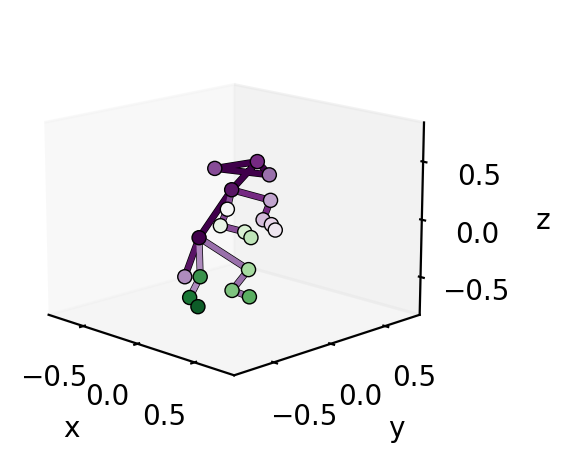

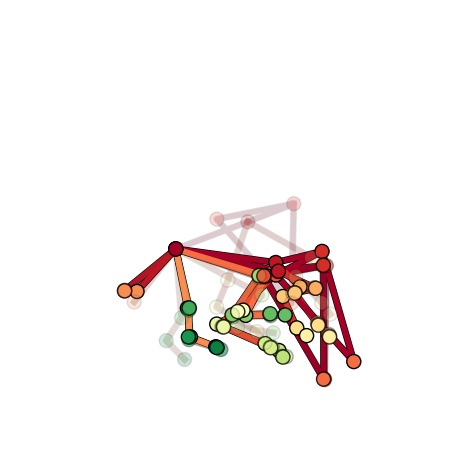

In [210]:
def plot_motif(
    to_plot, profile,
    ds_rate=4, 
    # plotting configurations
    figsize=(60, 60),
    limits3d=1, 
    keypoint_colormap = 'PiYG',
    view_init={"azim": -45, "elev": 15},
    node_size=30,
    keep_axis=False,
):
    w, h = figsize
    fig = plt.figure(figsize=(w*mm, h*mm), dpi=200)

    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    n_joints = to_plot.shape[1]
    kinematic_tree = profile.kinematic_tree

    cmap = plt.get_cmap(keypoint_colormap)
    joint_colors = []
    for chain in kinematic_tree:
        for idx in chain:
            if idx not in joint_colors:
                joint_colors.append(idx)
    joint_colors = [cmap(idx/n_joints) for idx in joint_colors]

    t = to_plot.shape[0]
    for frame in range(0, t, ds_rate):
        joints_output = to_plot[frame]

        for k in range(0, joints_output.shape[0]//n_joints):
            skeleton = joints_output[k*n_joints:(k+1)*n_joints]
            for e, chain in enumerate(kinematic_tree):
                # plot twice with different linewidths --> black line edge
                ax.plot3D(*skeleton[chain].T,
                    linewidth=2.0+0.5, color='k',
                    alpha=0.1 + 0.9*((frame+1)/t),
                    zorder=2
                )
                ax.plot3D(*skeleton[chain].T,
                    linewidth=2.0, color=cmap(e/n_joints),
                    alpha=0.1 + 0.9*((frame+1)/t),
                    zorder=3
                )
            
            ax.scatter(
                *skeleton.T,
                c=joint_colors,
                s=node_size,
                zorder=1,
                alpha=0.1 + 0.9*((frame+1)/t),
                linewidth=0,
            )
            ax.scatter(
                *skeleton.T,
                c=joint_colors,
                s=node_size+0.7,
                zorder=4,
                edgecolor="k",
                linewidth=0.5, alpha=0.1 + 0.9*((frame+1)/t)
            )

    ax.set_xlim([-limits3d, limits3d])
    ax.set_ylim([-limits3d, limits3d])
    ax.set_zlim([-limits3d, limits3d])
    ax.view_init(**view_init)
    ax.grid(False)

    if not keep_axis:
        ax.axis("off")

    plt.tight_layout()

# plot a single pose
plot_motif(poses_alignx[:1], profile, 
           limits3d=0.8, ds_rate=25, keypoint_colormap='PRGn', node_size=25, 
           keep_axis=True
)
# can plot as overlapping sequence
plot_motif(poses_alignx[200:301], profile, 
           limits3d=0.5, ds_rate=25, keypoint_colormap='RdYlGn', node_size=25, 
           keep_axis=False
)

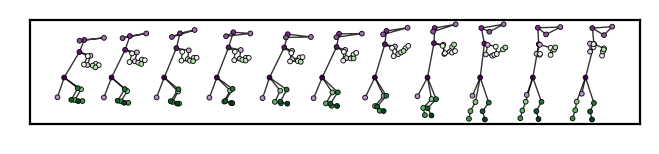

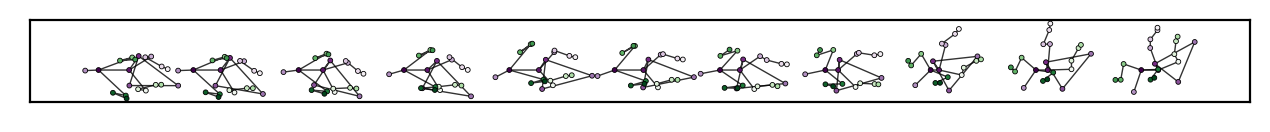

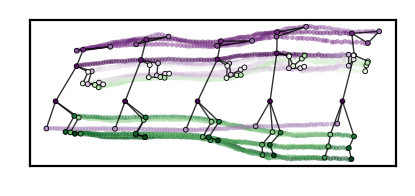

In [208]:
def plot_motif_planar(
    to_plot, profile,
    ds_rate=4, 
    # plotting configurations
    fig_size=(15, 40),
    keypoint_colormap = 'PiYG',
    node_size=1.5, 
    linewidth=0.6,
    vis_plane="xz",
    keep_middle=False,
    savepath=None,
    transparent=True,
):
    t = to_plot.shape[0]
    n_plots = t // ds_rate
    w, h = fig_size
    fig, ax = plt.subplots(1, 1, figsize=(w*n_plots*mm, h*mm), dpi=200)
    
    n_joints = to_plot.shape[1]
    kinematic_tree = profile.kinematic_tree
    cmap = plt.get_cmap(keypoint_colormap)
    
    for frame in range(t):
        joints_output = to_plot[frame]

        for k in range(0, joints_output.shape[0]//n_joints):
            skeleton = joints_output[k*n_joints:(k+1)*n_joints]
            if vis_plane == "xz":
                skeleton = skeleton[:, [0, 2]]
            elif vis_plane == "xy":
                skeleton = skeleton[:, [0, 1]]
            elif vis_plane == "yz":
                skeleton = skeleton[:, [1, 2]]
            else:
                raise TypeError
            
            skeleton[:, 0] += frame / ds_rate
            
            if keep_middle:
                ax.scatter(
                    *skeleton[1:].T,
                    c=np.arange(n_joints-1),
                    cmap=cmap,
                    s=node_size,
                    zorder=1,
                    linewidth=0, alpha=0.5
                )
            if (frame == 0 or (frame+1) % ds_rate == 0):
                for e, chain in enumerate(kinematic_tree):
                    ax.plot(*skeleton[chain].T,
                        linewidth=linewidth, color='k',
                        zorder=1, alpha=0.8
                    )
                ax.scatter(
                    *skeleton.T,
                    c=np.arange(n_joints),
                    cmap=cmap,
                    s=node_size,
                    zorder=2,
                    edgecolor="k", #alpha=0.4,
                    linewidth=0.3, 
                )

    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if savepath is not None:
        fig.savefig(savepath, transparent=transparent)

    
plot_motif_planar(
    poses_alignx[:100], profile, 
    fig_size=(10, 30),
    ds_rate=10, keypoint_colormap='PRGn', node_size=3, linewidth=0.5,
    vis_plane="xz"
)
plot_motif_planar(
    poses_alignx[:100], profile, 
    fig_size=(20, 20),
    ds_rate=10, keypoint_colormap='PRGn', node_size=3, linewidth=0.5,
    vis_plane="xy"
)
plot_motif_planar(
    poses_alignx[:100], profile, 
    fig_size=(15, 30),
    ds_rate=25, keypoint_colormap='PRGn', node_size=3, linewidth=0.5,
    vis_plane="xz", keep_middle=True,
    savepath='examples/figs/pose_sequence.png', transparent=False
)